In [5]:
# Uncomment below when working outside of home device
# data_dir = r'C:\Users\329982789\Desktop\ML for Trading\ML4T_2018Spring\ML4T_2018Spring\data' 
data_dir = r'C:\Users\jc1\Desktop\ML4T_2018Spring\ML4T_2018Spring\data'

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from scipy import optimize as opt
#from util import plot_data
from statsmodels.tsa.stattools import adfuller 

In [6]:
def symbol_to_path(symbol, base_dir=data_dir):
    """Return CSV file path given ticker symbol."""
    if base_dir is None:
        base_dir = os.environ.get("MARKET_DATA_DIR", '../data/')
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates, addSPY=True, colname = 'Adj Close'):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if addSPY and 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols = ['SPY'] + symbols

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', colname], na_values=['nan'])
        df_temp = df_temp.rename(columns={colname: symbol})
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])
    return df
syms=['GOOG','AAPL','GLD','XOM']
sd=dt.datetime(2010,1,1)
ed=dt.datetime(2012,1,30)
dates = pd.date_range(sd, ed)
prices_all = get_data(syms, dates)  # automatically adds SPY
prices = prices_all[syms]  # only portfolio symbols
prices_SPY = prices_all['SPY']  # only SPY, for comparison later
#training_index = [:'2012-01-01']  <-- Not working, will fix later
#testing_index = ['2012-01-01':]   <-- Not working, will fix later
# normalizing values
prices_norm = prices/prices.iloc[0]
SPY_norm = prices_SPY/prices_SPY.iloc[0]
# filling in nan values in data
prices_norm.fillna(method='ffill',inplace=True) 
#prices_norm.fillna(method='bfill', inplace=True)



In [7]:
# performs an Augmented Dickey-Fuller test to determine if the stock prices is a stationary time series or not.
# An Augmented Dickey-Fuller test tests a time series against the null hypothesis
# that there is a unit root contained in it.
# If the p_value is large (>0.05), it is likely that there is a unit root and thus the series is not stationary
# Otherwise, it is likely that the series is stationary   
for sym in syms:
    print('Asset: ', sym)
    adf_df = adfuller(prices_norm[sym])
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput, '\n')

# If you run this cell, you will see that the asset prices in this portfolio are not stationary time series
# since the p-values are much greater than 0.05, also notice has that the critical values are greater than the test statistic

Asset:  GOOG
test statistic           -2.490473
p-value                   0.117810
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 

Asset:  AAPL
test statistic           -0.291459
p-value                   0.926705
# of lags                 7.000000
# of observations       515.000000
Critical Value (1%)      -3.443112
Critical Value (5%)      -2.867168
Critical Value (10%)     -2.569768
dtype: float64 

Asset:  GLD
test statistic           -0.854066
p-value                   0.802723
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 

Asset:  XOM
test statistic           -0.660353
p-value                   0.856753
# of lags                 8.000000
# of observations       514.000000
Critical Value (1%)     

In [8]:
def turn_stationary(ts):
    # this function takes a time series (ts) as input and outputs a tuple containing the order of differencing
    # and a stationary version of ts
    # If ts is already stationary it returns a tuple with order of differencing 0 and the unmodified ts
    adf_df = adfuller(ts)
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    p_val = dfoutput.loc['p-value']
    # fills nan values
    differencing_order = 0
    iter = 0
    while p_val > 0.05:
        # fills nan values
        ts = ts.diff()
        ts.fillna(method='ffill', inplace=True)
        ts.fillna(method='bfill', inplace=True)
        adf_df = adfuller(ts)
        dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
        p_val = dfoutput.loc['p-value']
        differencing_order += 1
    lags = adf_df[2]
    observations = adf_df[3]
    return (differencing_order, lags, observations, ts)
    

Asset: AAPL
test statistic         -1.025711e+01
p-value                 4.332191e-18
# of lags               6.000000e+00
# of observations       5.160000e+02
Critical Value (1%)    -3.443087e+00
Critical Value (5%)    -2.867158e+00
Critical Value (10%)   -2.569762e+00
dtype: float64 



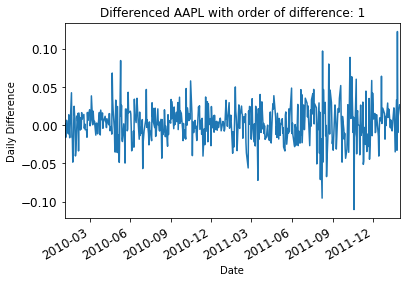

df head: 
 2010-01-04    0.001689
2010-01-05    0.001689
2010-01-06   -0.015908
2010-01-07   -0.001830
2010-01-08    0.006523
Name: AAPL, dtype: float64 

df tail: 
 2012-01-24   -0.032708
2012-01-25    0.122665
2012-01-26   -0.009479
2012-01-27    0.012389
2012-01-30    0.026748
Name: AAPL, dtype: float64 

1 
 6 
 516


In [9]:
# testing the turn_stationary function to differenced series and order of difference for the stock AAPL (Apple Corp.)

result = turn_stationary(prices_norm['AAPL'])
print('Asset: AAPL')
asset = result[3]
diff = result[0]
lags = result[1]
obs = result[2]
adf_df = adfuller(asset)
dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput, '\n')

title = 'Differenced AAPL with order of difference: ' + str(result[0])
ax = asset.plot(title=title, fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Difference')
plt.show()
print('df head: \n', asset.head(), '\n')
print('df tail: \n', asset.tail(), '\n')
print(diff, '\n', lags, '\n', obs)


In [10]:
# this cell print the order of difference for each column
stationary_assets = pd.DataFrame(index=dates)
stationary_assets.index.name = 'Date'

diff_orders = np.array([])
lags = np.array([])
observations = np.array([])

for sym in syms:
    tup = turn_stationary(prices_norm[sym])
    diff_order = tup[0]
    lag = tup[1]
    observation = tup[2]
    diff_orders = np.append(diff_orders,diff_order)
    lags = np.append(lags,lag)
    observations = np.append(observations, observation)
details = [diff_orders, lags, observations]

print(diff_orders)
print(lags)
print(observations)
details_df = pd.DataFrame([diff_orders, lags, observations])
details_df.columns = syms
print(details_df)

[ 1.  1.  1.  1.]
[ 0.  6.  0.  7.]
[ 522.  516.  522.  515.]
    GOOG   AAPL    GLD    XOM
0    1.0    1.0    1.0    1.0
1    0.0    6.0    0.0    7.0
2  522.0  516.0  522.0  515.0


In [11]:
# since each stationary series' order of difference is 1, I simply apply the 
# pd.diff() function to a copy of the original DataFrame prices_norm
stationary_df = prices_norm.copy()
stationary_df = stationary_df.diff()
stationary_df.fillna(method="ffill", inplace=True)
stationary_df.fillna(method="bfill", inplace=True)
print('df head: \n', stationary_df.head(), '\n')
print('df tail: \n', stationary_df.tail(), '\n')


df head: 
                 GOOG      AAPL       GLD       XOM
2010-01-04 -0.004404  0.001689 -0.000911  0.003873
2010-01-05 -0.004404  0.001689 -0.000911  0.003873
2010-01-06 -0.025098 -0.015908  0.016485  0.008675
2010-01-07 -0.022593 -0.001830 -0.006284 -0.003253
2010-01-08  0.012637  0.006523  0.005009 -0.004028 

df tail: 
                 GOOG      AAPL       GLD       XOM
2012-01-24 -0.007323 -0.032708 -0.010474 -0.004338
2012-01-25 -0.018253  0.122665  0.040164  0.000620
2012-01-26 -0.002218 -0.009479  0.007741 -0.006971
2012-01-27  0.018955  0.012389  0.015483 -0.014253
2012-01-30 -0.003654  0.026748 -0.008561 -0.005112 



Asset:  GOOG
test statistic          -22.974583
p-value                   0.000000
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 



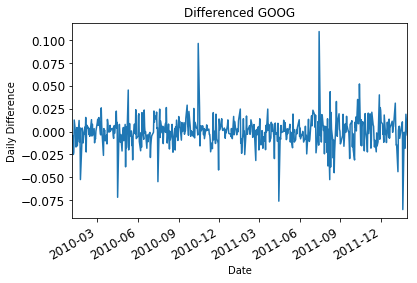

Asset:  AAPL
test statistic         -1.025711e+01
p-value                 4.332191e-18
# of lags               6.000000e+00
# of observations       5.160000e+02
Critical Value (1%)    -3.443087e+00
Critical Value (5%)    -2.867158e+00
Critical Value (10%)   -2.569762e+00
dtype: float64 



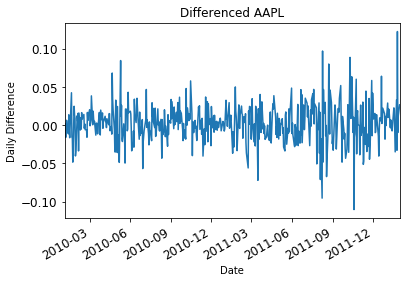

Asset:  GLD
test statistic          -23.617579
p-value                   0.000000
# of lags                 0.000000
# of observations       522.000000
Critical Value (1%)      -3.442940
Critical Value (5%)      -2.867093
Critical Value (10%)     -2.569727
dtype: float64 



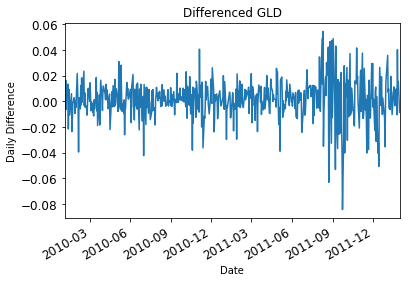

Asset:  XOM
test statistic         -8.209745e+00
p-value                 6.869501e-13
# of lags               7.000000e+00
# of observations       5.150000e+02
Critical Value (1%)    -3.443112e+00
Critical Value (5%)    -2.867168e+00
Critical Value (10%)   -2.569768e+00
dtype: float64 



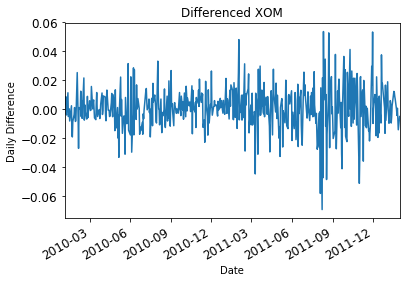

In [12]:
# performs an Augmented Dickey-Fuller test to determine if each column is a stationary time series or not.
# An Augmented Dickey-Fuller test tests a time series against the null hypothesis
# that there is a unit root contained in it.
# If the p_value is large (>0.05), it is likely that there is a unit root and thus the series is not stationary
# Otherwise, it is likely that the series is stationary   
# It will also plot the differenced series for each stock

lags = np.array([])
for sym in syms:
    print('Asset: ', sym)
    diff = stationary_df[sym]
    adf_df = adfuller(diff)
    dfoutput = pd.Series(adf_df[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key,value in adf_df[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput, '\n')
    title = 'Differenced ' + str(sym)
    ax = diff.plot(title=title, fontsize=12)
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Difference')
    plt.show()

# If you run this cell, you will see that the series in this portfolio are stationary time series
# since the p-values are much smaller than 0.05, note that all of the critical values are less than the test statistic

C:\Users\329982789\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\329982789\Documents\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.AAPL   No. Observations:                  522
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1188.213
Method:                       css-mle   S.D. of innovations              0.025
Date:                Fri, 20 Jul 2018   AIC                          -2370.425
Time:                        13:29:21   BIC                          -2357.652
Sample:                             1   HQIC                         -2365.423
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0021      0.001      1.964      0.050    4.61e-06       0.004
ar.L1.D.AAPL     0.0017      0.044      0.039      0.969      -0.084       0.087
                                    Roots   

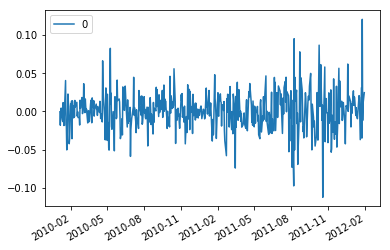

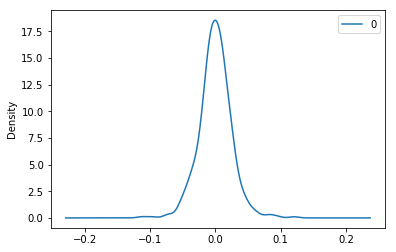

                  0
count  5.220000e+02
mean   6.089855e-09
std    2.486611e-02
min   -1.124774e-01
25%   -1.333882e-02
50%    1.334119e-04
75%    1.332867e-02
max    1.205855e-01


In [91]:
# the next few cells will focus on setting up an ARIMA model for each column in stationary_df for modelling purposes
# 
# but first I'll test it out on one of the columns of stationary_df
AAPL = prices_norm['AAPL']
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(AAPL, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

predicted=1.895547, expected=1.921492
predicted=1.922135, expected=1.931816
predicted=1.937570, expected=1.953261
predicted=1.953311, expected=1.973674
predicted=1.977373, expected=1.970577
predicted=1.970486, expected=1.977616
predicted=1.977238, expected=1.974378
predicted=1.975990, expected=1.968982
predicted=1.968636, expected=1.961614
predicted=1.963395, expected=1.984420
predicted=1.986599, expected=2.005068
predicted=2.010462, expected=1.998686
predicted=2.000292, expected=1.963867
predicted=1.962766, expected=1.997091
predicted=1.996874, expected=1.964383
predicted=1.969992, expected=2.087048
predicted=2.084579, expected=2.077569
predicted=2.096634, expected=2.089958
predicted=2.076778, expected=2.116706
Test MSE: 0.001


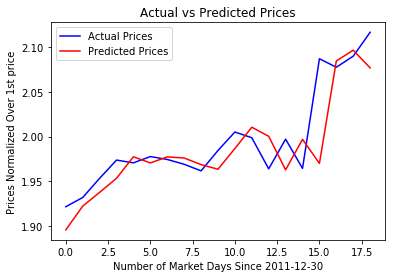

In [73]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
train = prices_norm['AAPL']['2010-01-01':'2011-12-30']
test = prices_norm['AAPL']['2012-01-02':'2012-01-30']
history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
plt.plot(test.tolist(),color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.ylabel('Prices Normalized Over 1st price')
plt.xlabel('Number of Market Days Since 2011-12-30')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

ValueError: ordinal must be >= 1

In [69]:
train1 = train['2010-01-04': '2010-01-30']
train1

2010-01-04    1.000000
2010-01-05    1.001689
2010-01-06    0.985781
2010-01-07    0.983951
2010-01-08    0.990474
2010-01-11    0.981746
2010-01-12    0.970577
2010-01-13    0.984280
2010-01-14    0.978555
2010-01-15    0.962224
2010-01-19    1.004786
2010-01-20    0.989301
2010-01-21    0.972220
2010-01-22    0.923979
2010-01-25    0.948850
2010-01-26    0.962271
2010-01-27    0.971328
2010-01-28    0.931206
2010-01-29    0.897419
Name: AAPL, dtype: float64

In [70]:
train2 = train['2009-01-04': '2009-01-30']
train2

Series([], Name: AAPL, dtype: float64)

,SPY,GOOG,AAPL,GLD,XOM
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN
2010-01-04,108.27,626.75,213.10,109.80,64.55
2010-01-05,108.56,623.99,213.46,109.70,64.80
2010-01-06,108.64,608.26,210.07,111.51,65.36
2010-01-07,109.10,594.10,209.68,110.82,65.15
2010-01-08,109.46,602.02,211.07,111.37,64.89
2010-01-09,NaN,NaN,NaN,NaN,NaN
2010-01-10,NaN,NaN,NaN,NaN,NaN
